r = 0.44086956521739135


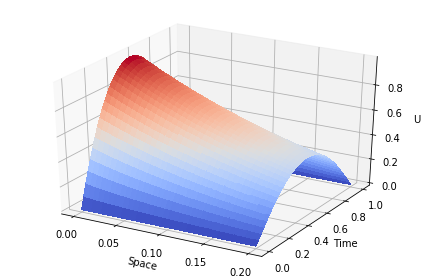

In [1]:
'''
Forward method to solve 1D reaction-diffusion equation:
    u_t = D * u_xx + alpha * u
    
with Dirichlet boundary conditions u(x0,t) = 0, u(xL,t) = 0
and initial condition u(x,0) = 4*x - 4*x**2
'''


import numpy as np
from scipy import sparse
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm


M = 40 # GRID POINTS on space interval
N = 70 # GRID POINTS on time interval

x0 = 0
xL = 1

# ----- Spatial discretization step -----
dx = (xL - x0)/(M - 1)

t0 = 0
tF = 0.2

# ----- Time step -----
dt = (tF - t0)/(N - 1)

D = 0.1  # Diffusion coefficient
alpha = -3 # Reaction rate

r = dt*D/dx**2
s = dt*alpha;

print("r =", r)

# ----- Creates grids -----
xspan = np.linspace(x0, xL, M)
tspan = np.linspace(t0, tF, N)

# ----- Initializes matrix solution U -----
U = np.zeros((M, N))

# ----- Initial condition -----
U[:,0] = 4*xspan - 4*xspan**2

# ----- Dirichlet Boundary Conditions -----
U[0,:] = 0.0
U[-1,:] = 0.0

# ----- Equation (15.8) in Lecture 15 -----
for k in range(0, N-1):
    for i in range(1, M-1):
        U[i, k+1] = r*U[i-1, k] + (1-2*r+s)*U[i,k] + r*U[i+1,k] 

X, T = np.meshgrid(tspan, xspan)

fig = plt.figure()
ax = fig.gca(projection='3d')

surf = ax.plot_surface(X, T, U, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

ax.set_xticks([0, 0.05, 0.1, 0.15, 0.2])

ax.set_xlabel('Space')
ax.set_ylabel('Time')
ax.set_zlabel('U')
plt.tight_layout()
plt.show()

True


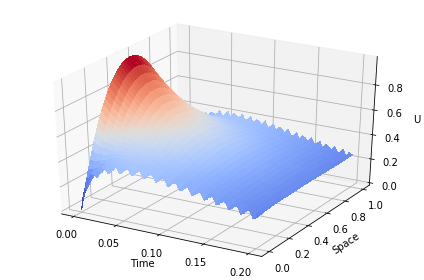

In [3]:
'''
Backward method to solve 1D reaction-diffusion equation:
    u_t = D * u_xx + alpha * u
    
with Neumann boundary conditions 
at x=0: u_x = sin(pi/2)
at x=L: u_x = sin(3*pi/4) with L=1
and initial condition u(x,0) = 4*x - 4*x**2
'''

import numpy as np
from scipy import sparse
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm


M = 50 # GRID POINTS on space interval
N = 60 # GRID POINTS on time interval

x0 = 0
xL = 1

# ----- Spatial discretization step -----
dx = (xL - x0)/(M - 1)

t0 = 0
tF = 0.2

# ----- Time step -----
dt = (tF - t0)/(N - 1)

D = 0.5  # Diffusion coefficient
alpha = -5 # Reaction rate

r = dt*D/dx**2
s = dt*alpha
a = 1 + 2*r - s


xspan = np.linspace(x0, xL, M)
tspan = np.linspace(t0, tF, N)

main_diag = (1 + 2*r - s)*np.ones((1,M))
off_diag = -r*np.ones((1, M-1))

a = main_diag.shape[1]

diagonals = [main_diag, off_diag, off_diag]

A = sparse.diags(diagonals, [0,-1,1], shape=(a,a)).toarray()
A[0,1] = -2*r
A[M-1,M-2] = -2*r

# ----- Initializes matrix U -----
U = np.zeros((M, N))

#----- Initial condition -----
U[:,0] = 4*xspan - 4*xspan**2

#----- Neumann boundary conditions -----
leftBC = np.arange(1, N+1)
f = np.sin(leftBC*np.pi/2)

rightBC = np.arange(1, N+1)
g = np.sin(3*rightBC*np.pi/4)


for k in range(1, N):
    c = np.zeros((M-2,1)).ravel()
    b1 = np.asarray([2*r*dx*f[k], 2*r*dx*g[k]])
    b1 = np.insert(b1, 1, c)
    b2 = np.array(U[0:M, k-1])
    b = b1 + b2  # Right hand side
    U[0:M, k] = np.linalg.solve(A,b)  # Solve x=A\b

# ----- Checks if the solution is correct:
gc = np.allclose(np.dot(A,U[0:M,N-1]), b)
print(gc)

# ----- Surface plot -----
X, T = np.meshgrid(tspan, xspan)

fig = plt.figure()
ax = fig.gca(projection='3d')

surf = ax.plot_surface(X, T, U, linewidth=0,
                       cmap=cm.coolwarm, antialiased=False)

ax.set_xticks([0, 0.05, 0.1, 0.15, 0.2])

ax.set_xlabel('Time')
ax.set_ylabel('Space')
ax.set_zlabel('U')
plt.tight_layout()
plt.show()

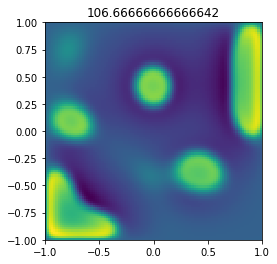

In [10]:
"""Pattern formation code

    Solves the pair of PDEs:
       u_t = D_1 \nabla^2 u + f(u,v)
       v_t = D_2 \nabla^2 v + g(u,v)
"""

import matplotlib
matplotlib.use('TkAgg')
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import spdiags,linalg,eye
from time import sleep

#Parameter values
Du=0.500; Dv=1;
delta=0.0045; tau1=0.02; tau2=0.2; alpha=0.899; beta=-0.91; gamma=-alpha;
#delta=0.0045; tau1=0.02; tau2=0.2; alpha=1.9; beta=-0.91; gamma=-alpha;
#delta=0.0045; tau1=2.02; tau2=0.; alpha=2.0; beta=-0.91; gamma=-alpha;
#delta=0.0021; tau1=3.5; tau2=0; alpha=0.899; beta=-0.91; gamma=-alpha;
#delta=0.0045; tau1=0.02; tau2=0.2; alpha=1.9; beta=-0.85; gamma=-alpha;
#delta=0.0001; tau1=0.02; tau2=0.2; alpha=0.899; beta=-0.91; gamma=-alpha;
#delta=0.0005; tau1=2.02; tau2=0.; alpha=2.0; beta=-0.91; gamma=-alpha; nx=150;

#Define the reaction functions
def f(u,v):
    return alpha*u*(1-tau1*v**2) + v*(1-tau2*u);

def g(u,v):
    return beta*v*(1+alpha*tau1/beta*u*v) + u*(gamma+tau2*v);


def five_pt_laplacian(m,a,b):
    """Construct a matrix that applies the 5-point laplacian discretization"""
    e=np.ones(m**2)
    e2=([0]+[1]*(m-1))*m
    h=(b-a)/(m+1)
    A=np.diag(-4*e,0)+np.diag(e2[1:],-1)+np.diag(e2[1:],1)+np.diag(e[m:],m)+np.diag(e[m:],-m)
    A/=h**2
    return A

def five_pt_laplacian_sparse(m,a,b):
    """Construct a sparse matrix that applies the 5-point laplacian discretization"""
    e=np.ones(m**2)
    e2=([1]*(m-1)+[0])*m
    e3=([0]+[1]*(m-1))*m
    h=(b-a)/(m+1)
    A=spdiags([-4*e,e2,e3,e,e],[0,-1,1,-m,m],m**2,m**2)
    A/=h**2
    return A

# Set up the grid
a=-1.; b=1.
m=100; h=(b-a)/m; 
x = np.linspace(-1,1,m)
y = np.linspace(-1,1,m)
Y,X = np.meshgrid(y,x)

# Initial data
u=np.random.randn(m,m)/2.;
v=np.random.randn(m,m)/2.;
plt.pcolormesh(x,y,u)
plt.colorbar; plt.axis('image'); 
plt.draw()
u=u.reshape(-1)
v=v.reshape(-1)

A=five_pt_laplacian_sparse(m,-1.,1.);
II=eye(m*m,m*m)

t=0.
dt=h/delta/5.;
plt.ion()

#Now step forward in time
for k in range(120):
    #Simple (1st-order) operator splitting:
    u = linalg.spsolve(II-dt*delta*Du*A,u)
    v = linalg.spsolve(II-dt*delta*Dv*A,v)

    unew=u+dt*f(u,v);
    v   =v+dt*g(u,v);
    u=unew;
    t=t+dt;

    #Plot every 3rd frame
    if k/3==float(k)/3:
        U=u.reshape((m,m))
        plt.pcolormesh(x,y,U)
        plt.colorbar
        plt.axis('image')
        plt.title(str(t))
        plt.draw()

plt.ioff()